## working with sentinelhub-py package

In [10]:
# install neccessary packages 

!pip install -r requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.6/245.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 3.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.2 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=ec7c9c2b869869d2e6b6c4d64a2061b51a045481cfb3e86a9facc7129f452c35
  Stored in directory: /home/codespace/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [47]:
%matplotlib inline

import datetime as dt
import getpass
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
from utils import plot_image

Searching available data

In [31]:
config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

In [32]:
from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'type': 'Catalog',
 'stac_version': '1.0.0',
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v1.0.0 implementation by Sentinel Hub',
 'conformsTo': ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson',
  'https://api.stacspec.org/v1.0.0/core',
  'https://api.stacspec.org/v1.0.0/collections',
  'https://api.stacspec.org/v1.0.0/ogcapi-features',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#fields',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#context',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#filter',
  'https://api.stacspec.org/v1.0.0/item-search',
  'https://api.stacspec.org/v1.0.0/item-search#fields',
  'https://api.stacspec.org/v1.0.0/item-search#context',
  'https://api.stacspec.org/v1.0.0/item-search#filter',
  'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter',
  'http

In [34]:
collections = catalog.get_collections()

collections = [collection for collection in collections if not collection["id"].startswith(("byoc", "batch"))]

collections

<function list.count(value, /)>

Trying to get map from the sentinel-2 L

In [35]:
Kibera = (36.781815,-1.313219,36.860092,-1.226829)

In [57]:
resolution = 1
Kibera_box = BBox(bbox=Kibera, crs=CRS.WGS84)
Kibera_size = bbox_to_dimensions(Kibera_box, resolution= resolution)

print(f"image shape at {resolution} m resolution: {Kibera_box} pixels")

image shape at 5 m resolution: 36.781815,-1.313219,36.860092,-1.226829 pixels


/tmp/ipykernel_5929/1900545450.py:5: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(f"image shape at {resolution} m resolution: {Kibera_box} pixels")


In [58]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=Kibera_box,
    size=Kibera_size,
    config=config,
)

In [59]:
true_color_imgs = request_true_color.get_data()

In [60]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1913, 1741, 3)


Image type: uint8


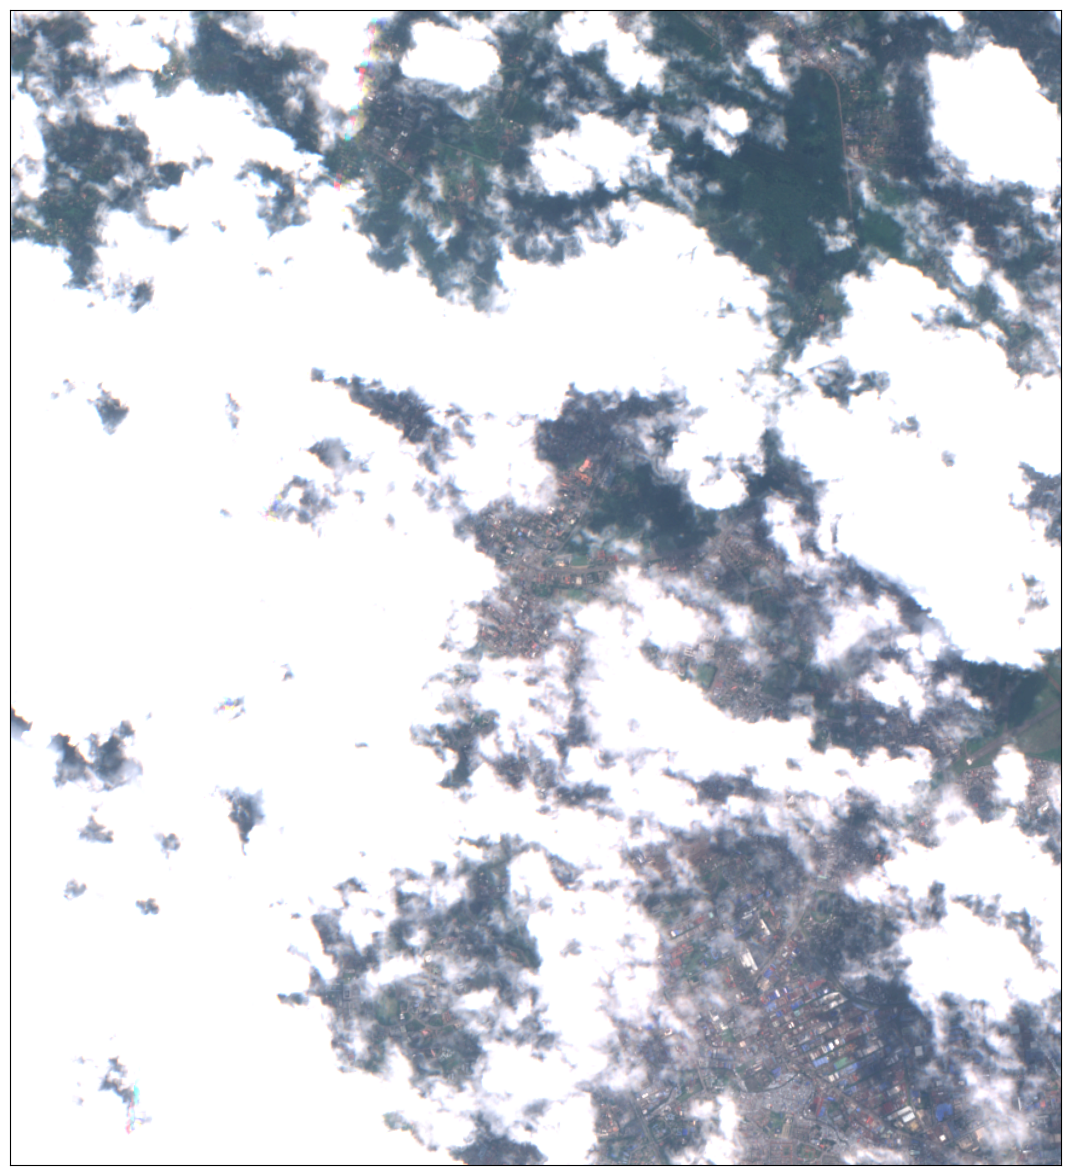

In [61]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [62]:
# to Remove clouds
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=Kibera_box,
    size=Kibera_size,
    config=config,
)

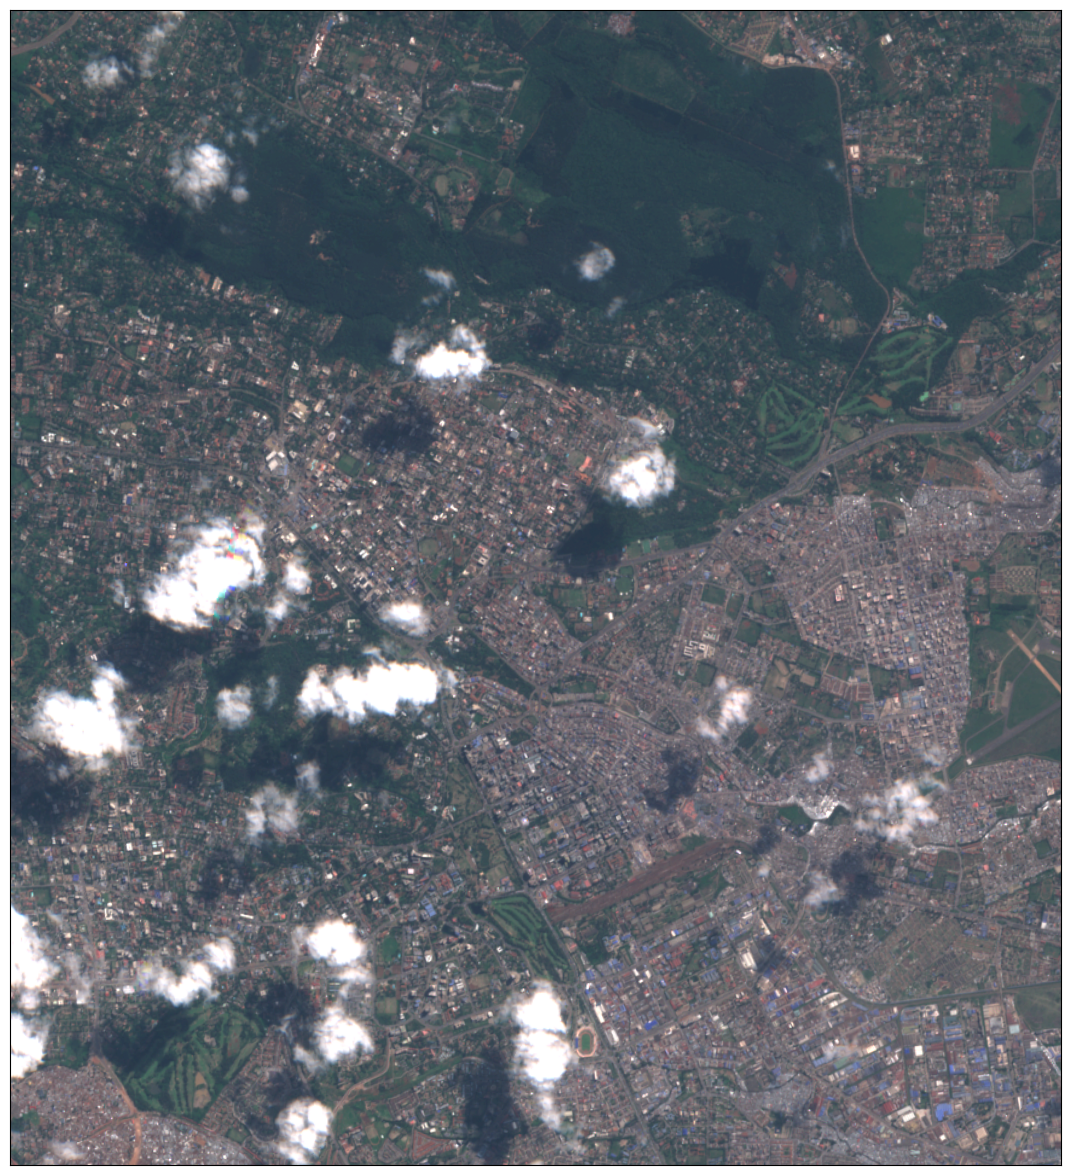

In [63]:
plot_image(request_true_color.get_data()[0], factor=3.5 / 255, clip_range=(0, 1))